# Мобильные приложения

**Выделение групп пользователей на основе поведения**

В нашем распоряжении данные о событиях, совершенных в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений.

В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.

## Знакомство с данными

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
from datetime import datetime, timedelta
from IPython.display import display_html
pd.set_option('display.max_columns', 30)
pd.set_option("display.float_format", "{:.3f}".format)

from statsmodels.stats.proportion import proportions_ztest

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import warnings
warnings.simplefilter('ignore')

In [2]:
# чтение файла с данными и сохранение в датафреймы
df = pd.read_csv('../../yandex-praktikum-sources/mobile_dataset.csv')
sources = pd.read_csv('../../yandex-praktikum-sources/mobile_sourсes.csv')

In [3]:
# просмотр информации о таблицах и проверка наличия дубликатов
d = {'mobile_dataset' : df, 'mobile_sourсes' : sources}
for a, i in d.items():
    print(f'Название датафрейма {a}, количество дубликатов {i.duplicated().sum()}')
    display(i.head())
    display(i.info())
    print('- ' * 50)

Название датафрейма mobile_dataset, количество дубликатов 0


event.time   event.name  \
0  2019-10-07 00:00:00.431357  advert_open   
1  2019-10-07 00:00:01.236320    tips_show   
2  2019-10-07 00:00:02.245341    tips_show   
3  2019-10-07 00:00:07.039334    tips_show   
4  2019-10-07 00:00:56.319813  advert_open   

                                user.id  
0  020292ab-89bc-4156-9acf-68bc2783f894  
1  020292ab-89bc-4156-9acf-68bc2783f894  
2  cf7eda61-9349-469f-ac27-e5b6f5ec475c  
3  020292ab-89bc-4156-9acf-68bc2783f894  
4  cf7eda61-9349-469f-ac27-e5b6f5ec475c

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


None

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Название датафрейма mobile_sourсes, количество дубликатов 0


userId  source
0  020292ab-89bc-4156-9acf-68bc2783f894   other
1  cf7eda61-9349-469f-ac27-e5b6f5ec475c  yandex
2  8c356c42-3ba9-4cb6-80b8-3f868d0192c3  yandex
3  d9b06b47-0f36-419b-bbb0-3533e582a6cb   other
4  f32e1e2a-3027-4693-b793-b7b3ff274439  google

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


None

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Согласно информации к данным:

Датасет `mobile_dataset.csv` содержит колонки:
- `event.time` — время совершения
- `event.name` — название события
- `user.id` — идентификатор пользователя

Датасет `mobile_sources.csv` содержит колонки:
- `userId` — идентификатор пользователя;
- `source` — источник, с которого пользователь установил приложение

Расшифровки событий:
- `advert_open` — открытие карточки объявления;
- `photos_show` — просмотр фотографий в объявлении;
- `tips_show` — пользователь увидел рекомендованные объявления;
- `tips_click` — пользователь кликнул по рекомендованному объявлению;
- `contacts_show` и `show_contacts` — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления;
- `contacts_call` — пользователь позвонил по номеру телефона на карточке объявления;
- `map` — пользователь открыл карту размещенных объявлений;
- `search_1` — `search_7` — разные события, связанные с поиском по сайту;
- `favorites_add` — добавление объявления в избранное.

Пропусков в данных нет, полных дубликатов тоже нет.

Для удобства переименуем столбцы таблиц в соответствии с snake_case

In [4]:
# переименование
df.columns = [x.replace('.', '_') for x in df.columns.values]
sources = sources.rename(columns={'userId' : 'user_id'})

События `contacts_show` и `show_contacts` дублируют друг друга. Посмотрим, какое из них более популярное, и заменим на него другое.

In [5]:
df.groupby('event_name')['event_time'].count().sort_values(ascending=False)

event_name
tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4450
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: event_time, dtype: int64

In [6]:
# замена 
df['event_name'] = df['event_name'].replace('show_contacts', 'contacts_show')

Проверим количество дубликатов после замены:

In [7]:
df.duplicated().sum()

0

Приведем столбец времени событий к временному типу и заодно добавим столбец с информацией только о дате.

In [8]:
# преобразование данных о времени
df['event_time'] = pd.to_datetime(df['event_time'])#.dt.round('1S')

# добавляем информацию о дне (без времени)
df['event_date'] = df['event_time'].dt.date

## Исследовательский анализ данных

### Распределение событий по времени

Проверим, какой период охватывают данные и насколько равномерно распределены события.

In [9]:
print(f'Время первого события {df.event_time.min()}')
print(f'Время последнего события {df.event_time.max()}')     

Время первого события 2019-10-07 00:00:00.431357
Время последнего события 2019-11-03 23:58:12.532487


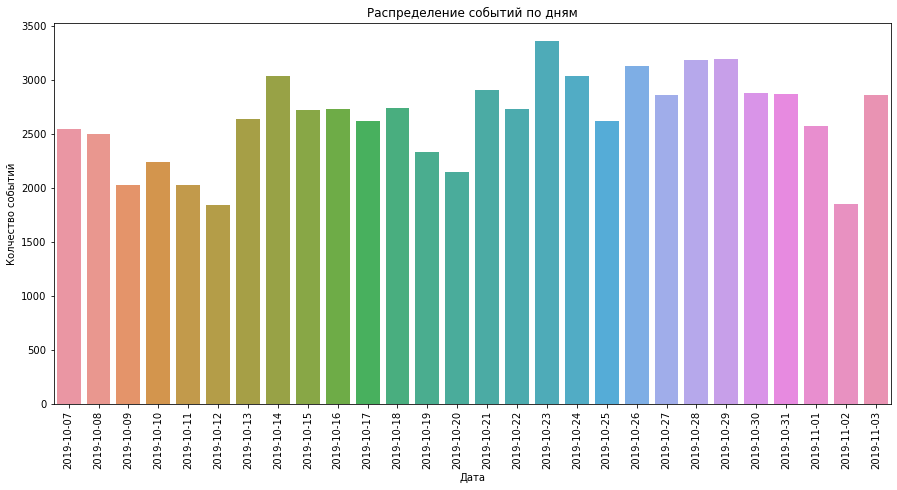

In [10]:
events_dates = df.groupby('event_date')[['event_name']].count().reset_index()

plt.figure(figsize = (15,7))
sns.barplot(x='event_date', y='event_name', data=events_dates)
plt.xticks(rotation=90)
plt.xlabel('Дата')
plt.ylabel('Колчество событий')
# plt.grid()
plt.title('Распределение событий по дням')
plt.show()

События по всему периоду сбора данных распределены равномерно, исключать какие-то даты из-за большой разницы в количестве событий не требуется.

### Распределение событий по пользователям

Сколько всего уникальных пользователей в данных?

In [11]:
df.user_id.nunique()

4293

Количество уникальных пользователей совпадает с размером таблицы `sources`.

Посмотрим, сколько событий приходится на пользователя. 

In [12]:
# группируем данные по пользователю и считаем количество событий
events_count = df.groupby('user_id')[['event_name']].count().reset_index()
print(f"Количество пользователей, совершивших лишь одно действие: {len(events_count[events_count['event_name'] == 1])}")
print(events_count.describe(percentiles=[0.05, 1/4, 1/2, 0.90, 0.95, 0.99]))

Количество пользователей, совершивших лишь одно действие: 65
       event_name
count    4293.000
mean       17.283
std        29.131
min         1.000
5%          3.000
25%         5.000
50%         9.000
90%        36.000
95%        59.000
99%       132.000
max       478.000


То есть 65 пользователей совершили всего одно действие, среднее количество действий - 17, медианное - 9, а фанаты приложения совершили за период сбора данных более 60 действий. 

При этом отметим, что количество событий пользователя и количество различных действий - отличаются.

In [13]:
df.groupby(['user_id'])['event_name'].nunique().reset_index()['event_name'].value_counts()

2     1365
1     1153
3      875
4      486
5      232
6      105
7       39
8       29
9        7
11       1
10       1
Name: event_name, dtype: int64

Для дальнейшего анализа следует исключить пользователей с всего однимм действием из анализа, признав их выбросами.

65 событий составляют менее 0,1% от объема собранных данных. 65 пользователей - 1,5% от всех уникальных пользователей в собранных данных.

In [14]:
drop_list = list(events_count[events_count['event_name'] == 1]['user_id'].unique())
df = df.query('user_id not in @drop_list')

### Сбор данных о сессиях

Для формирования профилей пользователей подготовим данные о сессия - сериях действий в приложении, совершенных за один заход. За разные сессии примем действия, отстоящие друг от друга на 3 часа. 

Кроме того, добавим к каждой сессии информацию о ее начале, конце, длительности и лайфтайму пользователя на момент этой сессии - время от первого захода в приложение до этой сессии в днях. Подсчитаем также, сколько действий за кажду сессию пользователь совершил.

Для подсчета количества сессий отсортируем данные по пользователям и времени и добавим столбцы `delta`  - время до предыдущего события и `session` - номер сессии пользователя, в которую попадает событие. 

In [15]:
# сортируем данные 
df = df.sort_values(['user_id', 'event_time']).reset_index(drop=True)

# добавляем пустой столбец под длительность сессии
df['delta'] = pd.Timedelta(seconds=0)

In [16]:
df['delta'] = (
    df.groupby('user_id')['event_time'].diff()
    .dt.total_seconds() # преобразуем в секунды
    .fillna(value=0) # nan заменим на нули - это первое действие каждого пользователя 
)

In [17]:
# принимаем за промежуток между сессиями 3 часа в секундах
session_break = 3 * 60 * 60
# создаем серию с признаком новой сессии
new_session = (df['delta'] == 0) | (df['delta'] > session_break)
# добавляем номера новых сессий в таблицу
df['session'] = df.loc[new_session == True, ['user_id', 'event_time']].groupby('user_id').rank(method='first').astype(int)
df['session'] = df['session'].fillna(method='ffill').astype(int)

df.head(20)

event_time event_name  \
0  2019-10-07 13:39:45.989359  tips_show   
1  2019-10-07 13:40:31.052909  tips_show   
2  2019-10-07 13:41:05.722489  tips_show   
3  2019-10-07 13:43:20.735461  tips_show   
4  2019-10-07 13:45:30.917502  tips_show   
5  2019-10-07 13:45:43.212340  tips_show   
6  2019-10-07 13:46:31.033718  tips_show   
7  2019-10-07 13:47:32.860234  tips_show   
8  2019-10-07 13:49:41.716617  tips_show   
9  2019-10-09 18:33:55.577963        map   
10 2019-10-09 18:35:28.260975        map   
11 2019-10-09 18:40:28.738785  tips_show   
12 2019-10-09 18:42:22.963948  tips_show   
13 2019-10-21 19:52:30.778932  tips_show   
14 2019-10-21 19:53:17.165009  tips_show   
15 2019-10-21 19:53:38.767230        map   
16 2019-10-21 19:54:45.009859  tips_show   
17 2019-10-21 19:54:56.854811  tips_show   
18 2019-10-21 19:56:49.417415        map   
19 2019-10-21 19:57:21.124551  tips_show   

                                 user_id  event_date       delta  session  
0   0001b1d5-b74a-4cbf-aeb0-7df5947bf349  2019-10-07       0.000        1  
1   0001b1d5-b74a-4cbf-aeb0-7df5947bf349  2019-10-07      45.064        1  
2   0001b1d5-b74a-4cbf-aeb0-7df5947bf349  2019-10-07      34.670        1  
3   0001b1d5-b74a-4cbf-aeb0-7df5947bf349  2019-10-07     135.013        1  
4   0001b1d5-b74a-4cbf-aeb0-7df5947bf349  2019-10-07     130.182        1  
5   0001b1d5-b74a-4cbf-aeb0-7df5947bf349  2019-10-07      12.295        1  
6   0001b1d5-b74a-4cbf-aeb0-7df5947bf349  2019-10-07      47.821        1  
7   0001b1d5-b74a-4cbf-aeb0-7df5947bf349  2019-10-07      61.827        1  
8   0001b1d5-b74a-4cbf-aeb0-7df5947bf349  2019-10-07     128.856        1  
9   0001b1d5-b74a-4cbf-aeb0-7df5947bf349  2019-10-09  189853.861        2  
10  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  2019-10-09      92.683        2  
11  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  2019-10-09     300.478        2  
12  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  2019-10-09     114.225        2  
13  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  2019-10-21 1041007.815        3  
14  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  2019-10-21      46.386        3  
15  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  2019-10-21      21.602        3  
16  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  2019-10-21      66.243        3  
17  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  2019-10-21      11.845        3  
18  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  2019-10-21     112.563        3  
19  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  2019-10-21      31.707        3

In [18]:
# создаем датафрейм с сессиями
sessions = df.groupby(['user_id', 'session']).agg({'event_time':['first', 'last'], 
                                                   'event_name':'count'}).reset_index()
sessions = sessions.set_axis(['user_id', 'session_n', 'session_start', 'session_end', 'events_count'], axis='columns')

# создаем датафрейм для самого первого события у каждого пользователя
user_start = df.groupby('user_id').agg({'event_time':'first'}).reset_index()
user_start.rename(columns={'event_time':'first_visit'}, inplace=True)

# присоединяем к данным о сессиях
sessions = sessions.merge(user_start, on='user_id', how='left')

# вычисляем лайфтайм для каждой сессии в днях
sessions['lifetime'] = (sessions['session_start'] - sessions['first_visit']).dt.days

# сохраняем отдельно день визита в приложение
sessions['dt'] = sessions['first_visit'].dt.date
# длительность сессии - как промежуток между первым и последним событием в сессии
sessions['length'] = sessions.session_end - sessions.session_start

# переведем в секунды
sessions['length'] = sessions['length'].dt.total_seconds()
sessions

user_id  session_n  \
0     0001b1d5-b74a-4cbf-aeb0-7df5947bf349          1   
1     0001b1d5-b74a-4cbf-aeb0-7df5947bf349          2   
2     0001b1d5-b74a-4cbf-aeb0-7df5947bf349          3   
3     0001b1d5-b74a-4cbf-aeb0-7df5947bf349          4   
4     00157779-810c-4498-9e05-a1e9e3cedf93          1   
...                                    ...        ...   
8543  fffb9e79-b927-4dbb-9b48-7fd09b23a62b         19   
8544  fffb9e79-b927-4dbb-9b48-7fd09b23a62b         20   
8545  fffb9e79-b927-4dbb-9b48-7fd09b23a62b         21   
8546  fffb9e79-b927-4dbb-9b48-7fd09b23a62b         22   
8547  fffb9e79-b927-4dbb-9b48-7fd09b23a62b         23   

                  session_start                session_end  events_count  \
0    2019-10-07 13:39:45.989359 2019-10-07 13:49:41.716617             9   
1    2019-10-09 18:33:55.577963 2019-10-09 18:42:22.963948             4   
2    2019-10-21 19:52:30.778932 2019-10-21 20:07:30.051028            14   
3    2019-10-22 11:18:14.635436 2019-10-22 11:30:52.807203             8   
4    2019-10-19 21:34:33.849769 2019-10-19 21:59:54.637098             9   
...                         ...                        ...           ...   
8543 2019-10-30 11:31:45.886946 2019-10-30 11:31:45.886946             1   
8544 2019-11-01 00:24:31.162871 2019-11-01 00:24:53.473219             2   
8545 2019-11-02 01:16:48.947231 2019-11-02 01:16:48.947231             1   
8546 2019-11-02 18:01:27.094834 2019-11-02 19:30:50.471310             6   
8547 2019-11-03 14:32:55.956301 2019-11-03 16:08:25.388712            29   

                    first_visit  lifetime          dt   length  
0    2019-10-07 13:39:45.989359         0  2019-10-07  595.727  
1    2019-10-07 13:39:45.989359         2  2019-10-07  507.386  
2    2019-10-07 13:39:45.989359        14  2019-10-07  899.272  
3    2019-10-07 13:39:45.989359        14  2019-10-07  758.172  
4    2019-10-19 21:34:33.849769         0  2019-10-19 1520.787  
...                         ...       ...         ...      ...  
8543 2019-10-12 00:57:21.241896        18  2019-10-12    0.000  
8544 2019-10-12 00:57:21.241896        19  2019-10-12   22.310  
8545 2019-10-12 00:57:21.241896        21  2019-10-12    0.000  
8546 2019-10-12 00:57:21.241896        21  2019-10-12 5363.376  
8547 2019-10-12 00:57:21.241896        22  2019-10-12 5729.432  

[8548 rows x 9 columns]

### Профили пользователей

Составим для каждого пользователя профиль - подсчитаем, сколько сессий в приложении совершил пользователь, сколько они длились, сколько всего времени было проведено в приложении, сколько действий в среднем за сессию пользователь совершал, а также информацию, совершил ли пользователь целевое действие - просмотр контактов продавца  и из какого источника пользователь установил приложение.

In [19]:
# составим профили пользователей
users_profiles = sessions.groupby('user_id').agg({'session_n' : 'max', 
                                                  'length':'sum', 
                                                  'events_count':'mean'}).reset_index()
# добавим информацию об источнике установки приложения
users_profiles = users_profiles.merge(sources, on='user_id', how='left')


# для каждого из событий составим столбец с признаком
for event in list(df['event_name'].unique()):
    event_users = list(df[df['event_name'] == event]['user_id'].unique())
    users_profiles[event] = False
    for user in event_users:
        users_profiles.loc[users_profiles['user_id'] == user, event] = True

display(users_profiles.head())
display(users_profiles.describe(percentiles=[0.05, 1/4, 1/2, 0.90, 0.95, 0.99]))

user_id  session_n    length  events_count  \
0  0001b1d5-b74a-4cbf-aeb0-7df5947bf349          4  2760.557         8.750   
1  00157779-810c-4498-9e05-a1e9e3cedf93          6 11774.209        11.833   
2  00463033-5717-4bf1-91b4-09183923b9df          1  1482.475        10.000   
3  004690c3-5a84-4bb7-a8af-e0c8f8fca64e          6  6644.359         5.333   
4  00551e79-152e-4441-9cf7-565d7eb04090          3   559.665         2.667   

   source  tips_show    map  search_1  photos_show  favorites_add  \
0   other       True   True     False        False          False   
1  yandex      False  False      True         True           True   
2  yandex      False  False     False         True          False   
3  google       True   True     False        False          False   
4  yandex      False  False      True         True          False   

   contacts_show  contacts_call  advert_open  search_7  search_5  search_4  \
0          False          False        False     False     False     False   
1           True           True         True     False     False     False   
2          False          False        False     False     False     False   
3          False          False         True      True      True      True   
4           True           True        False     False     False     False   

   search_6  search_3  tips_click  search_2  
0     False     False       False     False  
1     False     False       False     False  
2     False     False       False     False  
3      True      True       False     False  
4     False     False       False     False

session_n     length  events_count
count   4228.000   4228.000      4228.000
mean       2.022   3831.232         9.575
std        2.332  10734.760        10.019
min        1.000      0.000         1.000
5%         1.000     82.520         2.000
25%        1.000    430.546         4.000
50%        1.000   1167.406         6.306
90%        4.000   9251.179        19.000
95%        5.000  14709.368        27.000
99%       12.000  41491.474        50.000
max       39.000 353658.280       170.000

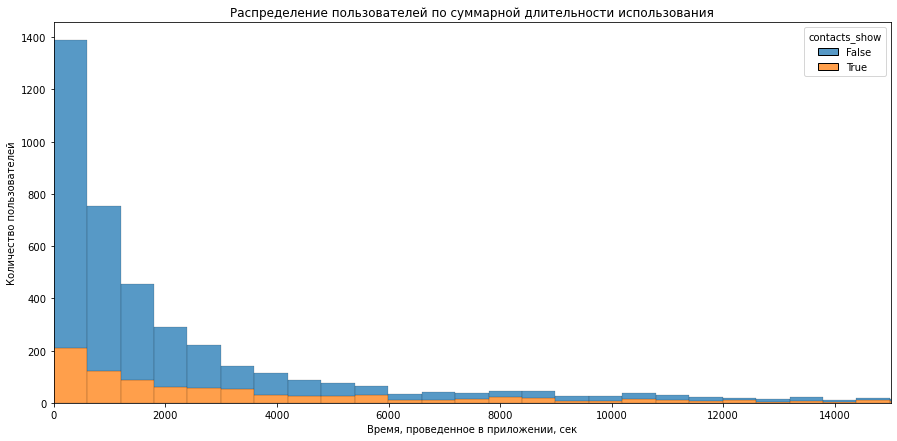

In [20]:
plt.figure(figsize = (15,7))
sns.histplot(x='length', data=users_profiles, hue= 'contacts_show', multiple='stack', bins=590)
plt.xlabel('Время, проведенное в приложении, сек')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей по суммарной длительности использования')
plt.xlim(0, 15000)
plt.show()

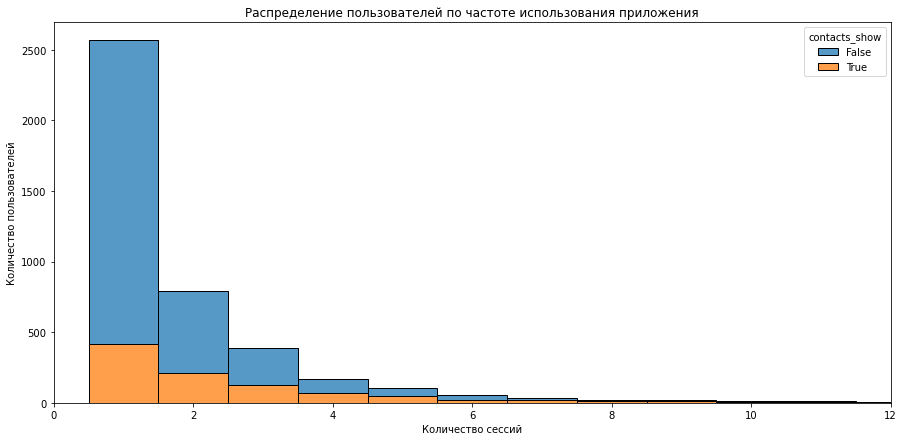

In [21]:
plt.figure(figsize = (15,7))
sns.histplot(x='session_n', data=users_profiles, hue='contacts_show', multiple='stack', discrete=True)
plt.xlabel('Количество сессий')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей по частоте использования приложения')
plt.xlim(0, 12)
plt.show()

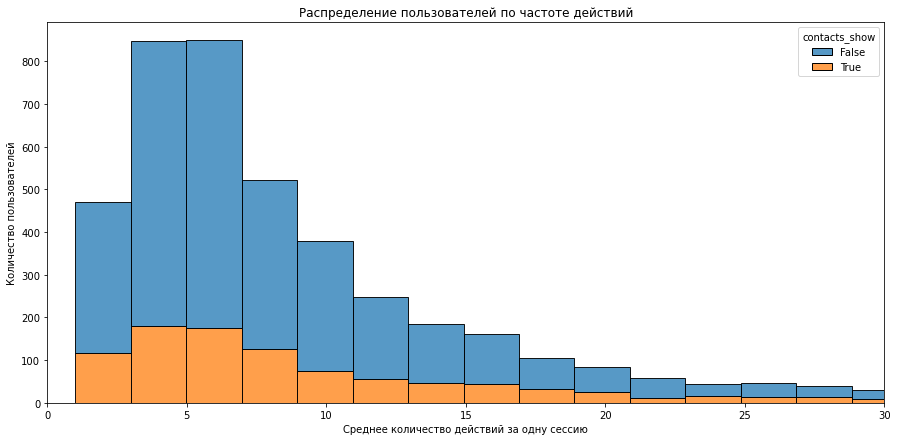

In [22]:
plt.figure(figsize = (15,7))
sns.histplot(x='events_count', data=users_profiles, hue= 'contacts_show', multiple='stack', bins=85)
plt.xlabel('Среднее количество действий за одну сессию')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей по частоте действий')
plt.xlim(0, 30)
plt.show()

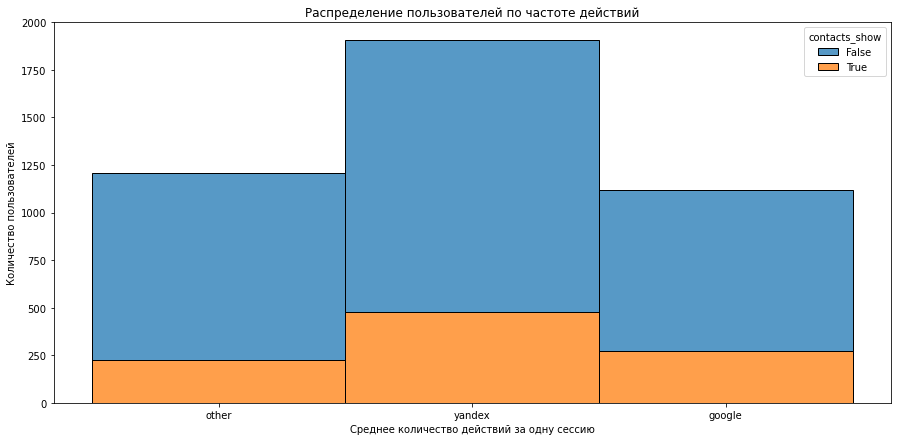

In [23]:
plt.figure(figsize = (15,7))
sns.histplot(x='source', data=users_profiles, hue= 'contacts_show', multiple='stack')
plt.xlabel('Среднее количество действий за одну сессию')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей по частоте действий')
plt.show()

In [24]:
# преобразуем источник установки в индикатор
users_profiles = pd.get_dummies(users_profiles, columns=['source'])

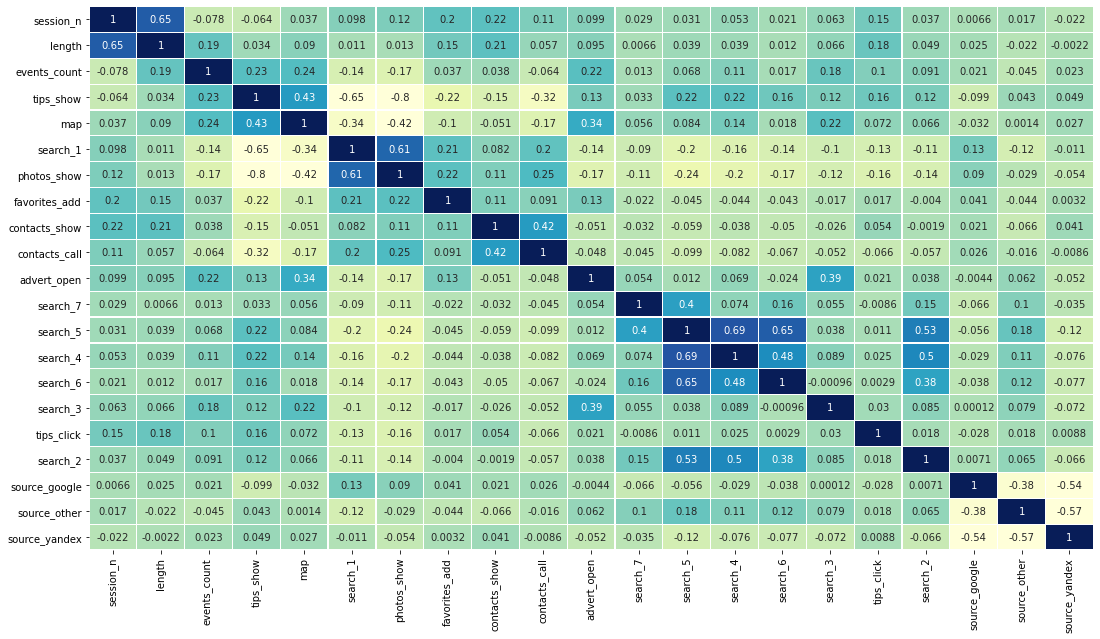

In [25]:
# матрица корреляций
plt.figure(figsize=(18, 10))
sns.heatmap(users_profiles.corr(), annot=True, cmap='YlGnBu', cbar=False, robust=True, linewidths=.2)
plt.show()

Сильная прямая корреляция заметна между суммарным временем, проведенным в приложении, и количеством сессий; между просмотром фотографий и поисковым событием №1; между некоторым поисковыми событиями; между просмотром карты и рекомендованных объявлений. 

Сильная обратная коререляция заметна между просмотром фотограций и рекомендованных объявлений; между просмотром рекомендованных объявлений и поисковым событием №1.

### Построение последовательностей событий и расчет конверсии

Для каждой сессии составим список событий по порядку их свершения, оставив только уникальные.

In [26]:
# функция для составления 
def sequence(sorted_data, user, session):
    sorted_user = sorted_data[(sorted_data['user_id']==user) &
                              (sorted_data['session']==session)].sort_values(by=['user_id','event_time'])
    return sorted_user['event_name'].drop_duplicates().to_list()

sequence_empty=[]
for i in df.user_id.unique():
    for j in range(1, df[df['user_id'] == i]['session'].max()+1):
        sequence_empty.append([i, j, sequence(df, i, j)])

path_data = pd.DataFrame(sequence_empty,columns=['user_id','session_n', 'path'])
# посмотрим, что получилось
path_data.head(10)

user_id  session_n  \
0  0001b1d5-b74a-4cbf-aeb0-7df5947bf349          1   
1  0001b1d5-b74a-4cbf-aeb0-7df5947bf349          2   
2  0001b1d5-b74a-4cbf-aeb0-7df5947bf349          3   
3  0001b1d5-b74a-4cbf-aeb0-7df5947bf349          4   
4  00157779-810c-4498-9e05-a1e9e3cedf93          1   
5  00157779-810c-4498-9e05-a1e9e3cedf93          2   
6  00157779-810c-4498-9e05-a1e9e3cedf93          3   
7  00157779-810c-4498-9e05-a1e9e3cedf93          4   
8  00157779-810c-4498-9e05-a1e9e3cedf93          5   
9  00157779-810c-4498-9e05-a1e9e3cedf93          6   

                                                path  
0                                        [tips_show]  
1                                   [map, tips_show]  
2                                   [tips_show, map]  
3                                   [map, tips_show]  
4                            [search_1, photos_show]  
5  [search_1, photos_show, favorites_add, contact...  
6                         [photos_show, advert_open]  
7  [search_1, photos_show, contacts_show, contact...  
8             [search_1, photos_show, contacts_show]  
9                                    [contacts_show]

In [27]:
path_data['path'].value_counts().head(15)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[tips_show]                        1935
[photos_show]                      1021
[map, tips_show]                    495
[search_1, photos_show]             487
[search_1]                          471
[tips_show, contacts_show]          262
[tips_show, map]                    183
[map, advert_open, tips_show]       155
[tips_show, tips_click]             148
[contacts_show]                     128
[photos_show, search_1]             103
[advert_open]                       100
[advert_open, tips_show]             89
[map]                                82
[map, tips_show, contacts_show]      81
Name: path, dtype: int64

In [28]:
# подсчитаем количество сессий, в которых были показаны контакты
path_data['contacts_shown'] = False
path_data['contacts_shown'] = path_data['path'].apply(lambda x: ('contacts_show' in x))
display(path_data[path_data['contacts_shown']==True].head(10))
print(f'Количество сессий, в которые были просмотрены контакты: {path_data.contacts_shown.sum()}')
print(f'Всего сессий: {len(path_data)}')
print(f'Доля успешных сессиий: {path_data.contacts_shown.sum() / len(path_data):.2%}')

user_id  session_n  \
5   00157779-810c-4498-9e05-a1e9e3cedf93          2   
7   00157779-810c-4498-9e05-a1e9e3cedf93          4   
8   00157779-810c-4498-9e05-a1e9e3cedf93          5   
9   00157779-810c-4498-9e05-a1e9e3cedf93          6   
17  00551e79-152e-4441-9cf7-565d7eb04090          1   
18  00551e79-152e-4441-9cf7-565d7eb04090          2   
21  005fbea5-2678-406f-88a6-fbe9787e2268          1   
25  00753c79-ea81-4456-acd0-a47a23ca2fb9          1   
28  007d031d-5018-4e02-b7ee-72a30609173f          1   
30  00a93a72-3bbc-4ee7-8a81-7134f45ae009          1   

                                                 path  contacts_shown  
5   [search_1, photos_show, favorites_add, contact...            True  
7   [search_1, photos_show, contacts_show, contact...            True  
8              [search_1, photos_show, contacts_show]            True  
9                                     [contacts_show]            True  
17                     [contacts_show, contacts_call]            True  
18           [search_1, contacts_show, contacts_call]            True  
21                         [contacts_show, tips_show]            True  
25                                    [contacts_show]            True  
28                    [map, tips_show, contacts_show]            True  
30                          [contacts_show, search_1]            True

Количество сессий, в которые были просмотрены контакты: 1498
Всего сессий: 8548
Доля успешных сессиий: 17.52%


In [29]:
path_data[path_data['contacts_shown']==True]['path'].value_counts().head(15)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[tips_show, contacts_show]                     262
[contacts_show]                                128
[map, tips_show, contacts_show]                 81
[contacts_show, contacts_call]                  80
[photos_show, contacts_show]                    75
[search_1, contacts_show, contacts_call]        51
[contacts_show, tips_show]                      48
[search_1, photos_show, contacts_show]          46
[photos_show, contacts_show, contacts_call]     38
[search_1, contacts_show]                       37
[contacts_show, photos_show]                    37
[tips_show, contacts_show, map]                 31
[contacts_show, contacts_call, photos_show]     29
[tips_show, map, contacts_show]                 25
[tips_show, contacts_show, tips_click]          24
Name: path, dtype: int64

Так как строго определенной воронки действий пользователя не удается выявить, за конверсию можно принять долю успешных сессиий. В таком случае конверсия в просмотр контактов составляет 17.52%.

In [30]:
print(f'Конверсия по уникальным пользователям: {users_profiles.contacts_show.sum() / len(users_profiles):.2%}')

Конверсия по уникальным пользователям: 23.06%


Если учитывать только успешных уникальных пользователей, конверсия составит 23,06%

Проанализируем, какие шаги предшествуют целевому действию - из составленных путей извлечем этапы до просмотра контактов, и подсчитаем, какие действия  встречаются чаще.

In [31]:
# вспомогательная таблица только с путями к успеху
success_paths = path_data.query('contacts_shown')[['path']].reset_index(drop=True)
# вычленим часть пути до успеха
success_paths['way'] = success_paths.apply(lambda row:row['path'][0:row['path'].index('contacts_show')], axis=1)
# список из всех этапов перед показом контактов
steps = pd.DataFrame(success_paths.way.sum(), columns =['events'])
steps['n'] = 1
# сгруппируем по событию
steps.groupby('events')['n'].count().sort_values(ascending = False)

events
tips_show        640
map              244
photos_show      239
search_1         213
advert_open      102
search_5          97
search_4          63
favorites_add     55
search_6          35
search_2          35
tips_click        29
search_3          23
search_7          11
Name: n, dtype: int64

Таким образом, чаще всего перед просмотром контактов пользователи просматривают рекомендованные объявления, карту с объявлениями, фотографии и пользуются функцией поиска-1.

Посмотрим, как отличаются сессии успешные и не успешные.

In [32]:
(
    sessions
    .merge(path_data[['user_id', 'session_n', 'contacts_shown']], on=['user_id', 'session_n'])
    .groupby('contacts_shown').agg({'events_count':'mean', 'length':'mean', 'lifetime':'mean'})
)

events_count   length  lifetime
contacts_shown                                 
False                  7.864 1545.830     2.962
True                  12.477 3538.281     3.085

В успешных сессиях в среднем больше действий, они длиннее, но по лайфтайму отличий почти нет. 

### Оценка влияния различных признаков на целевой

In [33]:
# выделим бинарные признаки
col_bi = []
for col in users_profiles.columns.values:
    if users_profiles[col].max() == 1 or users_profiles[col].max() == True:
        col_bi.append(col)
col_bi = sorted(col_bi)
len(col_bi)

18

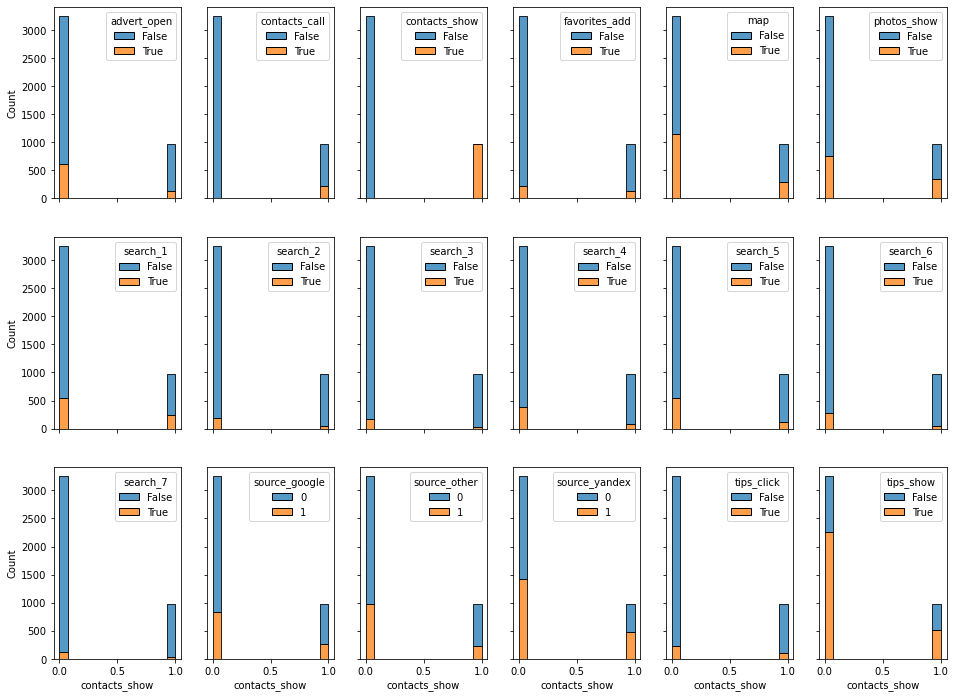

In [34]:
figs, axes = plt.subplots(3, 6, sharey = True, sharex = True, figsize=(16, 12))
try:
    for i in range(len(col_bi)):
#     users_profiles[i] = np.hstack((np.ones((5, ), dtype=bool), np.zeros((1000, ), dtype=bool)))
       sns.histplot(ax=axes[i//6, i%6], x='contacts_show', data=users_profiles, hue=col_bi[i], multiple='stack')
except:
    for i in range(len(col_bi)):
#     users_profiles[i] = np.hstack((np.ones((5, ), dtype=bool), np.zeros((1000, ), dtype=bool)))
        users_profiles['contacts_show'] = users_profiles['contacts_show'] * 1
        sns.histplot(ax=axes[i//6, i%6], x='contacts_show', data=users_profiles, hue=col_bi[i], multiple='stack')
plt.show() 

Из графиков можно увидеть:
- все, кто звонят продавцам, открывали контакты
- примерно половина тех, кто смотрит контакты, не видели рекомендованные объявления
- те, кто смотрят контакты, чаще добавляют объявления в избранное и чаще смотрят фотографии
- просмотр карты, открытие объявлений, клики по рекомендованным объявлениям, источник установки не оказывают заметного влияния на просмотр контактов

In [35]:
(
    users_profiles.groupby('contacts_show')
    .agg({'favorites_add':'mean', 
          'photos_show':'mean', 
          'search_1':'mean', 
          'tips_click':'mean', 
          'session_n':'mean', 
          'length':'mean', 'events_count':'mean'})
)

favorites_add  photos_show  search_1  tips_click  session_n  \
contacts_show                                                                
False                  0.066        0.231     0.168       0.068      1.745   
True                   0.139        0.348     0.243       0.103      2.944   

                length  events_count  
contacts_show                         
False         2608.794         9.365  
True          7909.786        10.275

## Кластеризация

### Иерархическая агломеративная кластеризация

In [36]:
#выделим из данных признаки (матрица X)
X = users_profiles.drop(['user_id'], axis=1)

In [37]:
# обязательная стандартизация данных перед работой с алгоритмами
sc = StandardScaler()
X_sc = sc.fit_transform(X)

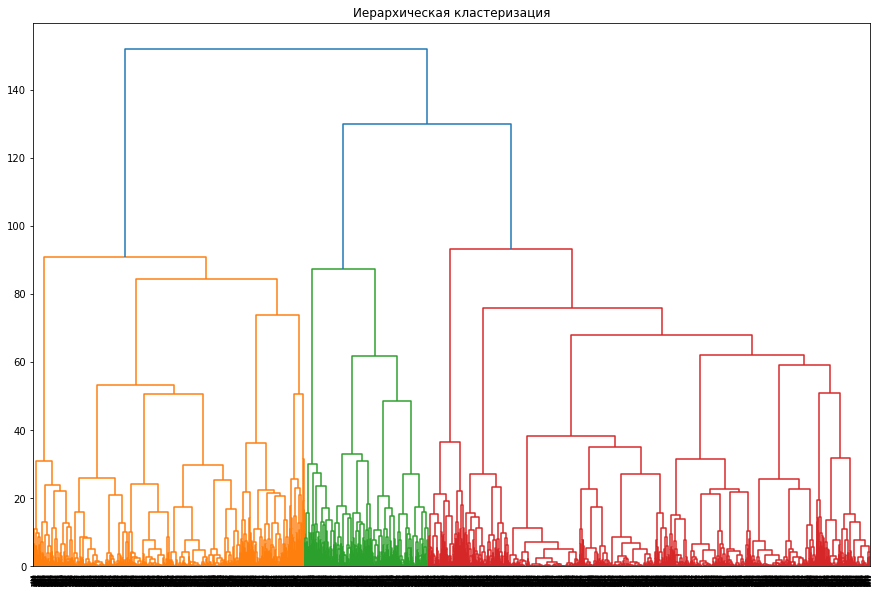

In [38]:
# построим матрицу расстояний
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show()

На основании цветов полученного графика можно сделать вывод, что оптимальное количество кластеров - три. 

### K-means

Метрика силуэта для 3 кластеров даже немного ниже, чем для 4, так что зададим число кластеров, равное четырем. 

In [39]:
# задаём число кластеров, равное 4, и фиксируем значение random_state для воспроизводимости результата
km = KMeans(n_clusters=4, random_state=0) 
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 3)
labels = km.fit_predict(X_sc)
# сохраняем метки кластера в поле нашего датасета
users_profiles['cluster_km'] = labels

In [40]:
# оценим метрику силуаэта для кластеризации
from sklearn.metrics import silhouette_score
silhouette_score(X_sc, labels)

0.20259218191767314

In [41]:
# выводим статистику по средним значениям всех признаков по кластеру
display(users_profiles.groupby('cluster_km').mean().T)

cluster_km           0        1        2        3
session_n        2.197    1.746    3.470    2.245
length        3059.008 3473.208 8471.939 4830.208
events_count     6.380   10.808    6.805   11.270
tips_show        0.007    0.942    0.009    0.898
map              0.003    0.495    0.005    0.446
search_1         0.634    0.000    0.521    0.008
photos_show      0.884    0.000    0.735    0.006
favorites_add    0.189    0.033    0.195    0.053
contacts_show    0.190    0.194    1.000    0.171
contacts_call    0.000    0.000    0.991    0.000
advert_open      0.055    0.232    0.098    0.207
search_7         0.001    0.004    0.000    0.224
search_5         0.002    0.017    0.000    0.961
search_4         0.001    0.019    0.000    0.668
search_6         0.000    0.001    0.000    0.509
search_3         0.002    0.066    0.000    0.084
tips_click       0.002    0.115    0.005    0.082
search_2         0.000    0.001    0.000    0.373
source_google    0.347    0.238    0.312    0.208
source_other     0.249    0.255    0.256    0.463
source_yandex    0.405    0.507    0.433    0.329

In [42]:
# количество пользователей в кластерах
users_profiles.groupby('cluster_km')['user_id'].count()

cluster_km
0    1050
1    2319
2     215
3     644
Name: user_id, dtype: int64

Судя по метрике силуэта, кластеризация не очень качественная, но некоторые различия между пользователями в кластерах заметны:

- Кластер №0: 
  - не смотрят объявления на карте
  - меньше всего времени провели в приложении
  - чаще всего смотрят фотографии
  - чаще всего пользуются поиском-1
  - почти не смотрят рекомендованные объявления
  - часто добавляют объявления в избранное
- Кластер №1:
  - чаще всех смотрят рекомендованные объявления
  - чаще всех смотрят объявления на карте
  - не смотрят фотографии
  - почти не добавляют объявления в избранное
  - чаще всех открывают карточки объявлений
- Кластер №2:
  - больше всего времени провели в приложении
  - наибольшее количество сессий
  - часто смотрят фотографии
  - чаще всех добавляют объявления в избранное
  - единственные звонят по объявлениям
  - все открывали контакты продавца
  - почти не смотрят рекомендованные объявления
  - не пользуются никаким поиском, кроме поиска-1
- Кластер №3:
  - активнее всех пользуются поиском
  - самое большое количество действий за сессию
  - почти не смотрят фотографии
  - часто смотрят рекомендованные объявления

## Расчет удержания

### Функция расчета удержания

Напишем функцию для создания таблицы удержания с возможностью передать ей признаки пользователей анализа разницы. 

In [43]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],  # новый параметр dimensions
    ignore_horizon=False,
):
    global sources
    
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = sessions.query('dt <= @last_suitable_acquisition_date')
    
    # собираем значения признаков для расчёта удержания
    result_raw = result_raw.merge(
        profiles.drop(['session_n', 'length', 'events_count'], axis=1), on='user_id', how='left')
    
    result_raw = result_raw.merge(sources, on='user_id', how='left')
        
    # рассчитываем удержание
    result_grouped = result_raw.pivot_table(
        index=dimensions,  # заменили dt
        columns='lifetime',
        values='user_id',
        aggfunc='nunique',
    )
    cohort_sizes = (
        result_raw.groupby(dimensions)  # заменили dt
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on=dimensions, how='left'  # заменили dt
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    return result_raw, result_grouped

Составим таблицу удержания из точки наблюдения 4 ноября (сразу после окончания сбора данных), с горизонтом 14 дней и разбивкой по созданным ранее кластерам.  

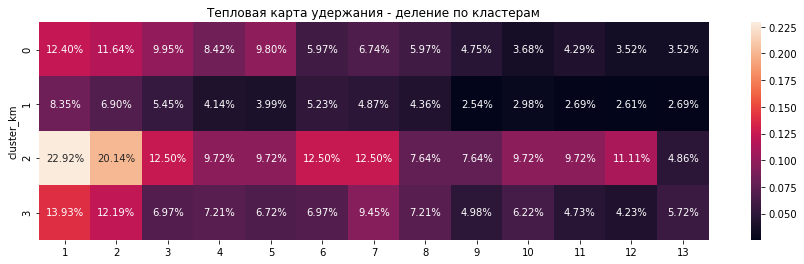

In [44]:
dim = ['cluster_km']
retention_raw, retention = get_retention(
    users_profiles, sessions, datetime(2019, 11, 4).date(), 14, dimensions=dim
) 

# строим хитмэп 
plt.figure(figsize=(15, 4)) 
sns.heatmap(retention.drop(columns=['cohort_size', 0]), annot=True,   fmt='.2%')
plt.title('Тепловая карта удержания - деление по кластерам')  
plt.show()

Активнее всего возвращаются пользователи в кластере №2, хуже всего - в кластере №3. 

Посмотрим, как отражаются те или иные признаки на удержании.

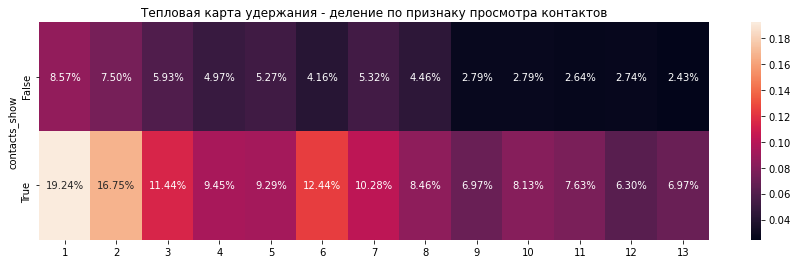

In [45]:
dim = ['contacts_show']
retention_raw, retention = get_retention(
    users_profiles, sessions, datetime(2019, 11, 4).date(), 14, dimensions=dim
) 

# строим хитмэп 
plt.figure(figsize=(15, 4)) 
sns.heatmap(retention.drop(columns=['cohort_size', 0]), annot=True,   fmt='.2%')
plt.title('Тепловая карта удержания - деление по признаку просмотра контактов')  
plt.show()

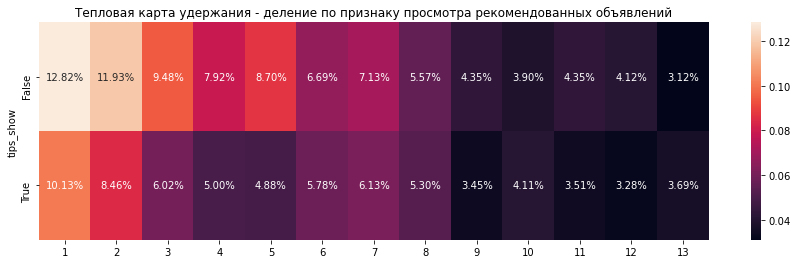

In [46]:
dim = ['tips_show']
retention_raw, retention = get_retention(
    users_profiles, sessions, datetime(2019, 11, 4).date(), 14, dimensions=dim
) 

# строим хитмэп 
plt.figure(figsize=(15, 4)) 
sns.heatmap(retention.drop(columns=['cohort_size', 0]), annot=True,   fmt='.2%')
plt.title('Тепловая карта удержания - деление по признаку просмотра рекомендованных объявлений')  
plt.show()

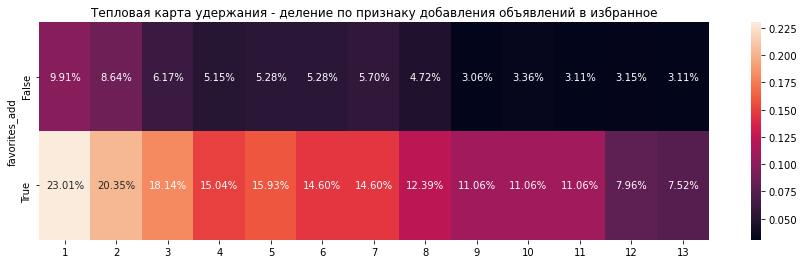

In [47]:
dim = ['favorites_add']
retention_raw, retention = get_retention(
    users_profiles, sessions, datetime(2019, 11, 4).date(), 14, dimensions=dim
) 

# строим хитмэп 
plt.figure(figsize=(15, 4)) 
sns.heatmap(retention.drop(columns=['cohort_size', 0]), annot=True,   fmt='.2%')
plt.title('Тепловая карта удержания - деление по признаку добавления объявлений в избранное')  
plt.show()

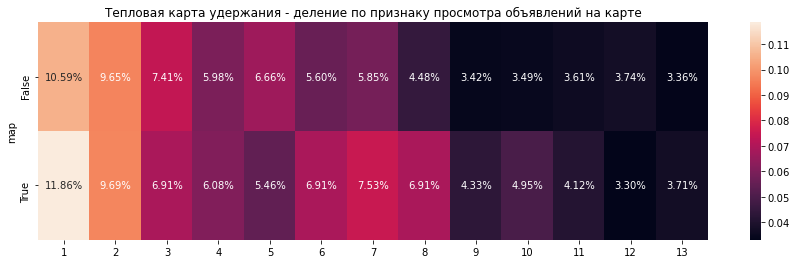

In [48]:
dim = ['map']
retention_raw, retention = get_retention(
    users_profiles, sessions, datetime(2019, 11, 4).date(), 14, dimensions=dim
) 

# строим хитмэп 
plt.figure(figsize=(15, 4)) 
sns.heatmap(retention.drop(columns=['cohort_size', 0]), annot=True,   fmt='.2%')
plt.title('Тепловая карта удержания - деление по признаку просмотра объявлений на карте')  
plt.show()

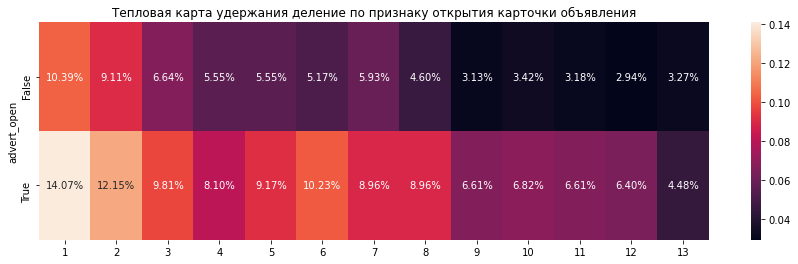

In [49]:
dim = ['advert_open']
retention_raw, retention = get_retention(
    users_profiles, sessions, datetime(2019, 11, 4).date(), 14, dimensions=dim
) 

# строим хитмэп 
plt.figure(figsize=(15, 4)) 
sns.heatmap(retention.drop(columns=['cohort_size', 0]), annot=True,   fmt='.2%')
plt.title('Тепловая карта удержания деление по признаку открытия карточки объявления')  
plt.show()

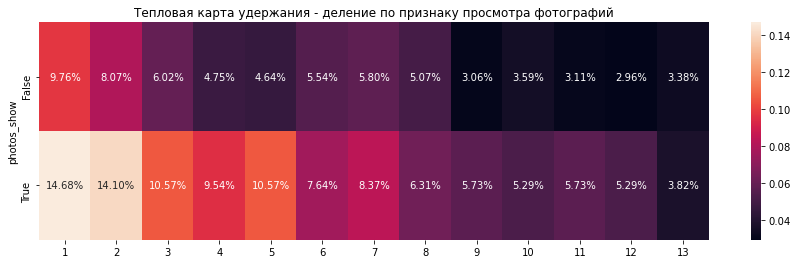

In [50]:
dim = ['photos_show']
retention_raw, retention = get_retention(
    users_profiles, sessions, datetime(2019, 11, 4).date(), 14, dimensions=dim
) 

# строим хитмэп 
plt.figure(figsize=(15, 4)) 
sns.heatmap(retention.drop(columns=['cohort_size', 0]), annot=True,   fmt='.2%')
plt.title('Тепловая карта удержания - деление по признаку просмотра фотографий')  
plt.show()

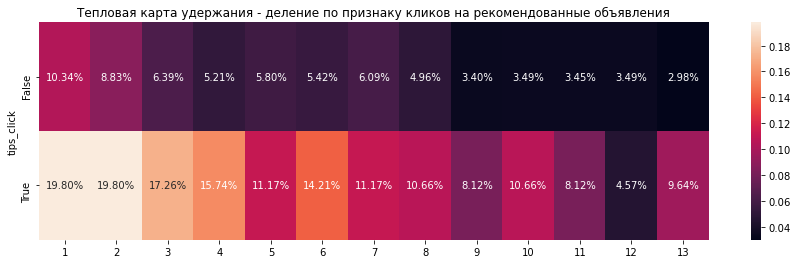

In [51]:
dim = ['tips_click']
retention_raw, retention = get_retention(
    users_profiles, sessions, datetime(2019, 11, 4).date(), 14, dimensions=dim
) 

# строим хитмэп 
plt.figure(figsize=(15, 4)) 
sns.heatmap(retention.drop(columns=['cohort_size', 0]), annot=True,   fmt='.2%')
plt.title('Тепловая карта удержания - деление по признаку кликов на рекомендованные объявления')  
plt.show()

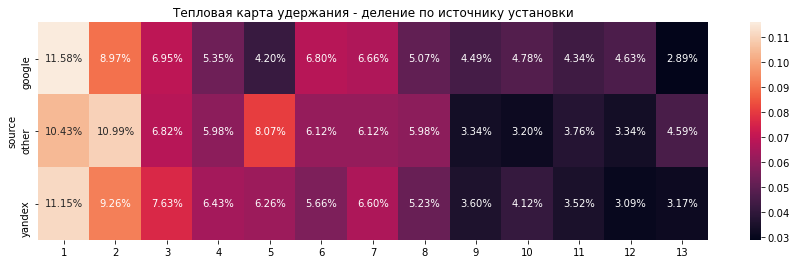

In [52]:
dim = ['source']
retention_raw, retention = get_retention(
    users_profiles, sessions, datetime(2019, 11, 4).date(), 14, dimensions=dim
) 

# строим хитмэп 
plt.figure(figsize=(15, 4)) 
sns.heatmap(retention.drop(columns=['cohort_size', 0]), annot=True,   fmt='.2%')
plt.title('Тепловая карта удержания - деление по источнику установки')  
plt.show()

Из тепловых карт видно, что пользователи, открывавшие контакты продавцов или добавлявшие объявления в в избранное, возвращаются активнее. 

Просмотр  объявлений на карте, просмотр фотографий не оказывают заметного влияния на удержание - хотя в первые несколько дней разница есть, к концу 14 дней остаются около 3-4% пользователей.

Источник установки также не оказывает драматического влияния на удержание.

Просмотр рекомендованных объявлений имеет обратный эффект - активнее возвращаются те пользователи, которые рекомендаций не видели. Возможно, в этом есть логика - не нашли искомого и вернулись, чтобы попытаться еще раз. 

Подсчитаем еще одну метрику - время между первым использованием приложения и каким-нибудь другим событием.

In [53]:
# дополнительно можно подсчитать долю успешных сессий в каждом кластере
(
    path_data.groupby('user_id', as_index=False)[['contacts_shown']].mean()
    .merge(users_profiles[['user_id', 'cluster_km']])
    .groupby('cluster_km')['contacts_shown'].mean()
)

cluster_km
0   0.128
1   0.151
2   0.724
3   0.101
Name: contacts_shown, dtype: float64

In [54]:
# функция для расчета по кластерам среднего времени от первого визита до первого интересующего нас события
def time_cluster(intresting_event):
    time_cluster = (
        df[['event_time', 'event_name', 'user_id']]
        .merge(users_profiles[['user_id', 'cluster_km']], on='user_id', how='left')
        .query('event_name == @intresting_event')
        .groupby('user_id', as_index=False)
        .agg({'event_time':'first'})
    )
    time_cluster = time_cluster.merge(sessions[['user_id', 'first_visit']], on='user_id', how='left')
    time_cluster = time_cluster.merge(users_profiles[['user_id', 'cluster_km']], on='user_id', how='left')
    time_cluster = time_cluster.drop_duplicates()
    time_cluster['delta'] = time_cluster['event_time'] - time_cluster['first_visit']
    time_cluster['delta'] = (time_cluster['delta'].dt.total_seconds()//(60*60)).astype(int)
    result = time_cluster.groupby('cluster_km')[['delta']].mean().rename(columns={'delta':'hours_to_event'})
    return result

In [55]:
time_cluster('tips_show')

hours_to_event
cluster_km                
0                   95.143
1                    1.359
2                    0.000
3                    7.112

In [56]:
time_cluster('favorites_add')

hours_to_event
cluster_km                
0                   31.207
1                   42.364
2                   55.024
3                   81.794

In [57]:
time_cluster('contacts_show')

hours_to_event
cluster_km                
0                   39.465
1                   19.713
2                   28.405
3                   52.327

In [58]:
time_cluster('search_7')

hours_to_event
cluster_km                
0                    0.000
1                   36.200
3                   25.417

Никакой характерной связи между временем совершения действия  и удержанием или конверсией мне заметить не удается. 

Самый успешный и активнее возвращающийся кластер №2 вообще не смотрит рекомендованные объявления, только через два с половиной дня что-то добавляет в избранное, и только спустя более чем сутки смотрит контакты.

Класте №1 показывает худшее удержание и успех всего в 15% сессий, но смотрит контакты менее, чем через сутки после первого визита, а  всего через полтора часа видит рекомендованные объявления.

Удивительно еще и то, как же пользователи кластера 2 вообще находят объявления. Из всех поисковых опций они пользуются только №1, и только половина пользователей в кластере. Рекомендованных объявлений они не видят. При этом времени в приложении проводят больше всех. 


## Проверка статистических гипотез

### Влияние источника установки приложения

Некоторые пользователи установили приложение по ссылке из `yandex`, другие — из `google`. Проверим гипотезу: две эти группы
демонстрируют разную конверсию в просмотры контактов.

**Гипотеза H0**: между пользователями, установившими приложение из разных источников, нет значимой разницы.

**Гипотеза H1**: значимая разница есть. 

Для проверки гипотезы проверим, какое количество пользователей совершило целевое действие (без учета количества сессий). 

In [59]:
target_source = (users_profiles
                 .merge(sources, on='user_id', how='left')
                 .pivot_table(index='source', 
                              values=['contacts_show', 'user_id'],
                              aggfunc={'user_id':'count','contacts_show':'sum'})
                )
target_source = target_source.rename(columns={'user_id' : 'total'})
target_source

contacts_show  total
source                      
google            274   1117
other             225   1206
yandex            476   1905

In [60]:
# статистическое сравнение долей 

alpha = 0.05

stat, pval = proportions_ztest(np.array([target_source.loc['google', 'contacts_show'], 
                                         target_source.loc['yandex', 'contacts_show']]), 
                               np.array([target_source.loc['google', 'total'], 
                                         target_source.loc['yandex', 'total']]))
print('{0:0.3f}'.format(pval))

if (pval < alpha): 
        print("Отвергаем нулевую гипотезу, между выборками есть статистически значимые различия.")
else:
        print("Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет.")

0.779
Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет.


С высокой вероятностью между пользователями, установившими приложение из разных источников, нет значимой разницы. 

Можно сделать вывод, что источник установки на конверсию не влияет.

### Добавление объявлений в "избранное"

Мне кажется интересным проверить, насколько успешен механизм рекомендаций объявлений. Для этого я хочу оценить, чаще ли пользователи добавляют в избранное объявления, рекомендованные приложением, чем найденные поиском. 

**Гипотеза H0**: между пользователями, добавившими объявления в избранное после поиска, и пользователями, добавившими объявления в избранное после клика по рекомендованному объявлению, нет значимой разницы.

**Гипотеза H1**: значимая разница есть.

Будем оценивать события внутри одной сессии. Добавим в ранее составленный список последовательностей действий столбцы, отражающие использование поиска, показ рекомендаций и добавление в избранное объявлений.

In [61]:
# признак - добавление в избранное
path_data['favorited'] = False
path_data['favorited'] = path_data['path'].apply(lambda x: ('favorites_add' in x))

In [62]:
# признак - клик по рекомендации
path_data['tips_clicked'] = False
path_data['tips_clicked'] = path_data['path'].apply(lambda x: ('tips_click' in x))

In [63]:
# признак - использование поиска
path_data['searched'] = False
for i in range(len(path_data)):
    for j in range(1, 8):
        if 'search_'+str(j) in path_data.loc[i, 'path']:
            path_data.loc[i, 'searched'] = True

In [64]:
# проверим, что получилось
path_data.head(10)

user_id  session_n  \
0  0001b1d5-b74a-4cbf-aeb0-7df5947bf349          1   
1  0001b1d5-b74a-4cbf-aeb0-7df5947bf349          2   
2  0001b1d5-b74a-4cbf-aeb0-7df5947bf349          3   
3  0001b1d5-b74a-4cbf-aeb0-7df5947bf349          4   
4  00157779-810c-4498-9e05-a1e9e3cedf93          1   
5  00157779-810c-4498-9e05-a1e9e3cedf93          2   
6  00157779-810c-4498-9e05-a1e9e3cedf93          3   
7  00157779-810c-4498-9e05-a1e9e3cedf93          4   
8  00157779-810c-4498-9e05-a1e9e3cedf93          5   
9  00157779-810c-4498-9e05-a1e9e3cedf93          6   

                                                path  contacts_shown  \
0                                        [tips_show]           False   
1                                   [map, tips_show]           False   
2                                   [tips_show, map]           False   
3                                   [map, tips_show]           False   
4                            [search_1, photos_show]           False   
5  [search_1, photos_show, favorites_add, contact...            True   
6                         [photos_show, advert_open]           False   
7  [search_1, photos_show, contacts_show, contact...            True   
8             [search_1, photos_show, contacts_show]            True   
9                                    [contacts_show]            True   

   favorited  tips_clicked  searched  
0      False         False     False  
1      False         False     False  
2      False         False     False  
3      False         False     False  
4      False         False      True  
5       True         False      True  
6      False         False     False  
7       True         False      True  
8      False         False      True  
9      False         False     False

Подсчитаем размеры выборок, которые нужно сравнить.

In [65]:
# поискали и добавили в избранное
s_1 = len(path_data.query('searched == True and favorited == True'))
# кликнули по рекомендации и добавили в избранное
s_2 = len(path_data.query('tips_clicked == True and favorited == True'))
# всего искали
t_1 = len(path_data.query('searched == True'))
# всего кликали по рекомендациям
t_2 = len(path_data.query('tips_clicked == True'))

In [66]:
alpha = 0.05

stat, pval = proportions_ztest(np.array([s_1, s_2]), 
                               np.array([t_1, t_2]))
print('{0:0.3f}'.format(pval))

if (pval < alpha): 
        print("Отвергаем нулевую гипотезу, между выборками есть статистически значимые различия.")
else:
        print("Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет.")

0.060
Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет.


Проверим, будет ли результат иным, если рассматривать не сессии, а уникальных пользователей.

In [67]:
# поискали и добавили в избранное
s_1 = len(users_profiles.query(("(search_1 == True or search_2 == True or search_3 == True or search_4 == True or search_5 == True or search_6 == True  or search_7 == True) and favorites_add == True")))
# кликнули по рекомендации и добавили в избранное
s_2 = len(users_profiles.query('tips_click == True and favorites_add == True'))
# всего искали
t_1 = len(users_profiles.query('search_1 == True or search_2== True or search_3== True or search_4== True or search_5== True or search_6== True  or search_7 == True'))
# всего кликали по рекомендациям
t_2 = len(users_profiles.query('tips_click == True'))

In [68]:
alpha = 0.05

stat, pval = proportions_ztest(np.array([s_1, s_2]), 
                               np.array([t_1, t_2]))
print('{0:0.3f}'.format(pval))

if (pval < alpha): 
        print("Отвергаем нулевую гипотезу, между выборками есть статистически значимые различия.")
else:
        print("Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет.")

0.265
Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет.


Итак, вне зависимости от подхода, статистически значимых различий в выборках нет. С высокой вероятностью путь, по которому пользователь нашел понравившееся объявление, не имеет значения. Видимо, система рекомендаций не так хороша, или поиск, напротив, очень точный. 

## Выводы

В приложение чаще возвращаются пользователи, которые или достигли своих целей (просмотрели контакты продавца, а значит, скорее всего нашли требуемое), либо полны надежд на успех (отложили объявление в избранное и собираются к нему вернуться), или рекомендованное объявление настолько их заинтересовало, что они по нему кликнули. 

При этом ни факт просмотра фотографий, ни просмотр объявлений на карте, ни источник установки приложения не оказывают на двухнедельном горизонте заметного влияния на удержание пользователей.

Чаще совершают целевое действие - просмотр контактов - те, кто добавил объявление в избранное и просмотрел фотографии. Источник установки (`google` или `yandex`) на конверсию статистически значимого влияния не оказывает. Среди тех, кто совершил целевое действие, 14% добавляли объявления в избранное, 35% смотрели фотографии, 24% использовали опцию поиска-1 и 10% кликали по рекомендованному объявлению. Среди тех, кто контактов не открывал, доли совершивших перечисленные действия были меньше (7, 23, 17 и 7% соответственно).

На добавление объявление в избранное не оказывает значимого влияния способ, которым пользователь его нашел - самостоятельно, поиском, или увидел в рекомендованных.

Чаще всего к просмотру контактов ведет просмотр рекомендованных объявлений, карты с объявлениями, фотографий и функция поиска-1.

В успешных сессиях в среднем больше действий (12 против 8), и они длиннее (1 час против 26 минут). Пользователи, просмотревшие контакты, чаще заходят в приложение (3 сессии против 1,7 за период сбора данных), больше времени в нем проводят (в среднем суммарно 2 часа 12 минут против 44 минут) и совершают в среднем больше действий за сессию (10 против 9).



## Презентация 

<a href='https://docs.google.com/presentation/d/1YJYLsv25bIHt5hRbwUv7dK1xCvRQFUl94GGqMglzNPs/edit?usp=sharing'> Ссылка на Гугл-презентацию </a>

<a href='https://drive.google.com/file/d/1-Pcrv1rPHd5tIoz51FFwdfc4Ny49t2nv/view?usp=sharing'> Ссылка на презентацию в формате pdf</a>

    